---

### 🎓 **Professor**: Apostolos Filippas

### 📘 **Class**: AI Engineering

### 📋 **Homework 4**: Embeddings & Semantic Search

### 📅 **Due Date**: Day of Lecture 5, 11:59 PM


**Note**: You are not allowed to share the contents of this notebook with anyone outside this class without written permission by the professor.

---

In this homework, you'll build on Homework 3 (BM25 search) by adding **embedding-based semantic search**.

You will:
1. **Generate embeddings** using both local (Hugging Face) and API (OpenAI) models
2. **Implement cosine similarity** from scratch
3. **Implement semantic search** from scratch
4. **Compare BM25 vs semantic search** using Recall
5. **Compare different embedding models** and analyze their differences

**Total Points: 95**

---

## Instructions

- Complete all tasks by filling in code where you see `# YOUR CODE HERE`
- You may use ChatGPT, Claude, documentation, Stack Overflow, etc.
- When using external resources, briefly cite them in a comment
- Run all cells before submitting to ensure they work

**Submission:**
1. Create a branch called `homework-4`
2. Commit and push your work
3. Create a PR and merge to main
4. Submit the `.ipynb` file on Blackboard

---

## Task 1: Environment Setup (10 points)

### 1a. Imports (5 pts)

Import the required libraries and load the WANDS data.

In [21]:
# ruff: noqa: E402

# Standard imports
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import time
import Stemmer
import string
import warnings
warnings.filterwarnings("ignore")

# Import ONLY data loading from helpers
import sys
sys.path.append('../scripts')
from helpers import load_wands_products, load_wands_queries, load_wands_labels

# Embedding libraries - we use these directly
from sentence_transformers import SentenceTransformer
import litellm

# Load environment variables for API keys
from dotenv import load_dotenv
load_dotenv()

pd.set_option('display.max_colwidth', 80)
print("All imports successful!")

All imports successful!


In [3]:
# Load the WANDS dataset
products = load_wands_products()
queries = load_wands_queries()
labels = load_wands_labels()

print(f"Products: {len(products):,}")
print(f"Queries: {len(queries):,}")
print(f"Labels: {len(labels):,}")

Products: 42,994
Queries: 480
Labels: 233,448


### 1b. Copy BM25 functions from HW3 (5 pts)

Copy your BM25 implementation from Homework 3. We'll use it to compare against semantic search.

In [10]:
# Copy your BM25 functions from Homework 3
# Provided functions - run this cell to define them

stemmer = Stemmer.Stemmer('english')
punct_trans = str.maketrans({key: ' ' for key in string.punctuation})

def snowball_tokenize(text: str) -> list[str]:
    """
    Tokenize text with Snowball stemming.
    
    Args:
        text: The text to tokenize
        
    Returns:
        List of stemmed tokens
    """
    if pd.isna(text) or text is None:
        return []
    text = str(text).translate(punct_trans)
    tokens = text.lower().split()
    return [stemmer.stemWord(token) for token in tokens]

def build_index(docs: list[str], tokenizer) -> tuple[dict, list[int]]:
    """
    Build an inverted index from a list of documents.
    
    Args:
        docs: List of document strings to index
        tokenizer: Function that takes text and returns list of tokens
        
    Returns:
        index: dict mapping term -> {doc_id: term_count}
        doc_lengths: list of document lengths (in tokens)
    """
    index = {}
    doc_lengths = []
    
    for doc_id, doc in enumerate(docs):
        tokens = tokenizer(doc)
        doc_lengths.append(len(tokens))
        term_counts = Counter(tokens)
        
        for term, count in term_counts.items():
            if term not in index:
                index[term] = {}
            index[term][doc_id] = count
    
    return index, doc_lengths

def get_tf(term: str, doc_id: int, index: dict) -> int:
    """
    Get term frequency for a term in a document.
    
    Args:
        term: The term to look up
        doc_id: The document ID
        index: The inverted index
        
    Returns:
        Term frequency (count), or 0 if not found
    """
    if term in index and doc_id in index[term]:
        return index[term][doc_id]
    return 0

def get_df(term: str, index: dict) -> int:
    """
    Get document frequency for a term.
    
    Args:
        term: The term to look up
        index: The inverted index
        
    Returns:
        Number of documents containing the term
    """
    if term in index:
        return len(index[term])
    return 0

def bm25_idf(df: int, num_docs: int) -> float:
    """
    BM25 IDF formula.
    
    Args:
        df: Document frequency
        num_docs: Total number of documents
        
    Returns:
        IDF score
    """
    return np.log((num_docs - df + 0.5) / (df + 0.5) + 1)

def bm25_tf(tf: int, doc_len: int, avg_doc_len: float, k1: float = 1.2, b: float = 0.75) -> float:
    """
    BM25 TF normalization.
    
    Args:
        tf: Term frequency
        doc_len: Document length in tokens
        avg_doc_len: Average document length
        k1: Saturation parameter (default 1.2)
        b: Length normalization (default 0.75)
        
    Returns:
        Normalized TF score
    """
    return (tf * (k1 + 1)) / (tf + k1 * (1 - b + b * doc_len / avg_doc_len))

def score_bm25(query: str, index: dict, num_docs: int, doc_lengths: list[int], 
               tokenizer, k1: float = 1.2, b: float = 0.75) -> np.ndarray:
    """
    Score all documents using BM25.
    
    Args:
        query: The search query
        index: Inverted index
        num_docs: Total number of documents
        doc_lengths: List of document lengths
        tokenizer: Tokenization function
        
    Returns:
        Array of scores for each document
    """
    query_tokens = tokenizer(query)
    scores = np.zeros(num_docs)
    avg_doc_len = np.mean(doc_lengths) if doc_lengths else 1.0
    
    for token in query_tokens:
        df = get_df(token, index)
        if df == 0:
            continue
        
        idf = bm25_idf(df, num_docs)
        
        if token in index:
            for doc_id, tf in index[token].items():
                tf_norm = bm25_tf(tf, doc_lengths[doc_id], avg_doc_len, k1, b)
                scores[doc_id] += idf * tf_norm
    
    return scores

def search_products(query: str, products_df: pd.DataFrame, index: dict, 
                    doc_lengths: list[int], tokenizer, k: int = 10) -> pd.DataFrame:
    """
    Search products and return top-k results.
    
    Args:
        query: The search query
        products_df: DataFrame of products
        index: Inverted index
        doc_lengths: Document lengths
        tokenizer: Tokenization function
        k: Number of results to return
        
    Returns:
        DataFrame with top-k products and scores
    """
    scores = score_bm25(query, index, len(products_df), doc_lengths, tokenizer)
    top_k_idx = np.argsort(-scores)[:k]
    
    results = products_df.iloc[top_k_idx].copy()
    results['score'] = scores[top_k_idx]
    results['rank'] = range(1, k + 1)
    return results

print("All functions defined!")


All functions defined!


---

## Task 2: Understanding Embeddings (15 points)

### 2a. Load a local model and generate embeddings (5 pts)

Use `sentence-transformers` to load a local embedding model and generate embeddings for a list of words.

In [14]:
# Load the all-MiniLM-L6-v2 model using SentenceTransformer
# Then generate embeddings for each word in the list
words = ["wooden coffee table", "oak dining table", "red leather sofa", "blue area rug", "kitchen sink"]

# Load the local embedding model
model = SentenceTransformer("all-MiniLM-L6-v2")
# Generate embeddings for all words (encode returns a 2D array: num_words x embedding_dim)
embeddings = model.encode(words)

# Print the number of embeddings you generated and the dimension of the embeddings
print(f"Number of embeddings: {len(embeddings)}")
print(f"Dimension of each embedding: {embeddings.shape[1]}")

Loading weights: 100%|██████████| 103/103 [00:00<00:00, 708.83it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Number of embeddings: 5
Dimension of each embedding: 384


### 2b. Implement cosine similarity and create a similarity matrix (5 pts)

Implement cosine similarity from scratch:

$$\text{cosine\_similarity}(a, b) = \frac{a \cdot b}{\|a\| \times \|b\|}$$

In [15]:
# Implement cosine similarity from scratch
# Formula: cosine_similarity(a, b) = (a · b) / (||a|| × ||b||)
def cosine_similarity(a: np.array, b: np.array) -> float:  
    return float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))

# Create similarity matrix (pairwise cosine similarity for all words)
n = len(embeddings)
similarity_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        similarity_matrix[i, j] = cosine_similarity(embeddings[i], embeddings[j])

# Display as DataFrame
similarity_df = pd.DataFrame(similarity_matrix, index=words, columns=words)
similarity_df


,wooden coffee table,oak dining table,red leather sofa,blue area rug,kitchen sink
wooden coffee table,1.000000,0.588631,0.370622,0.189486,0.295712
oak dining table,0.588631,1.000000,0.337910,0.249521,0.341410
red leather sofa,0.370622,0.337910,1.000000,0.380310,0.057740
blue area rug,0.189486,0.249521,0.380310,1.000000,0.125802
kitchen sink,0.295712,0.341410,0.057740,0.125802,1.000000


### 2c. Embed using OpenAI API (5 pts)

Use `litellm` to get embeddings from OpenAI's API and compare dimensions.

In [16]:
# Use litellm to get an embedding from OpenAI's text-embedding-3-small model
response = litellm.embedding(model="text-embedding-3-small", input=["wooden coffee table"])
openai_embedding = np.array(response.data[0]["embedding"])

# Compare the dimension with the local model
local_dim = embeddings.shape[1]
openai_dim = len(openai_embedding)
print(f"Local model (all-MiniLM-L6-v2) embedding dimension: {local_dim}")
print(f"OpenAI (text-embedding-3-small) embedding dimension: {openai_dim}")
print(f"OpenAI has {openai_dim - local_dim} more dimensions than the local model.")

Local model (all-MiniLM-L6-v2) embedding dimension: 384
OpenAI (text-embedding-3-small) embedding dimension: 1536
OpenAI has 1152 more dimensions than the local model.


---

## Task 3: Batch Embedding Products (20 points)

### 3a. Embed a product sample (10 pts)

Create a combined text field and embed 5,000 products using the local model.

In [17]:
# Get a consistent sample of 5,000 products (fixed seed for reproducibility)
products_sample = products.sample(n=5000, random_state=42).reset_index(drop=True)
print(f"Sampled {len(products_sample):,} products")


Sampled 5,000 products


In [18]:
# Create a combined text field (product_name + product_class)
products_sample["combined_text"] = (
    products_sample["product_name"].fillna("").astype(str) + " " +
    products_sample["product_class"].fillna("").astype(str)
).str.strip()

# Then embed all products using model.encode()
product_embeddings = model.encode(products_sample["combined_text"].tolist(), show_progress_bar=True)
print(f"Embeddings shape: {product_embeddings.shape}")


Batches: 100%|██████████| 157/157 [00:09<00:00, 17.20it/s]

Embeddings shape: (5000, 384)


### 3b. Save and load embeddings (5 pts)

Save embeddings to a `.npy` file so you don't have to recompute them.

In [19]:
# Save embeddings to ../temp/hw4_embeddings.npy
# Save products_sample to ../temp/hw4_products.csv
from pathlib import Path
temp_dir = Path("../temp")
temp_dir.mkdir(parents=True, exist_ok=True)

np.save(temp_dir / "hw4_embeddings.npy", product_embeddings)
products_sample.to_csv(temp_dir / "hw4_products.csv", index=False)

# Then load them back and verify they match
loaded_embeddings = np.load(temp_dir / "hw4_embeddings.npy")
loaded_products = pd.read_csv(temp_dir / "hw4_products.csv")

print("Verification:")
print(f"  Embeddings match: {np.allclose(product_embeddings, loaded_embeddings)}")
print(f"  Products shape match: {products_sample.shape == loaded_products.shape}")
# CSV round-trip can change dtypes; check key column (product_id) matches
products_match = (products_sample.shape == loaded_products.shape and
                  (products_sample["product_id"] == loaded_products["product_id"]).all())
print(f"  Products IDs match: {products_match}")

Verification:
  Embeddings match: True
  Products shape match: True
  Products IDs match: True


### 3c. Cost estimation (5 pts)

Estimate the cost to embed all 43K products using OpenAI's API.

**Pricing**: text-embedding-3-small costs ~$0.02 per 1 million tokens.

In [20]:
# Use tiktoken to count actual tokens in the sample
# OpenAI text-embedding-3-small uses cl100k_base encoding
import tiktoken
enc = tiktoken.get_encoding("cl100k_base")

sample_texts = products_sample["combined_text"].tolist()
sample_tokens = sum(len(enc.encode(text)) for text in sample_texts)
tokens_per_product = sample_tokens / len(products_sample)

# Then extrapolate to estimate cost for the full dataset
num_full_products = len(products)
estimated_total_tokens = tokens_per_product * num_full_products
price_per_million = 0.02
estimated_cost_usd = (estimated_total_tokens / 1_000_000) * price_per_million

print(f"Sample: {len(products_sample):,} products, {sample_tokens:,} total tokens ({tokens_per_product:.1f} tokens/product)")
print(f"Full dataset: {num_full_products:,} products")
print(f"Estimated total tokens: {estimated_total_tokens:,.0f}")
print(f"Estimated cost (text-embedding-3-small @ ${price_per_million}/1M tokens): ${estimated_cost_usd:.4f}")


Sample: 5,000 products, 64,753 total tokens (13.0 tokens/product)
Full dataset: 42,994 products
Estimated total tokens: 556,798
Estimated cost (text-embedding-3-small @ $0.02/1M tokens): $0.0111


---

## Task 4: Semantic Search (25 points)

### 4a. Implement semantic search (15 pts)

Implement a semantic search function from scratch.

In [27]:
# Implement batch cosine similarity for efficiency
# query_emb: (d,), doc_embs: (n, d) -> returns (n,) similarity scores
def batch_cosine_similarity(query_emb: np.ndarray, doc_embs: np.ndarray) -> np.ndarray:
    """Cosine similarity between one query vector and each document embedding."""
    query_norm = query_emb / np.linalg.norm(query_emb)
    doc_norms = doc_embs / np.linalg.norm(doc_embs, axis=1, keepdims=True)
    return doc_norms @ query_norm


In [25]:
# Implement semantic search
def semantic_search(
    query: str,
    product_embeddings: np.ndarray,
    products_df: pd.DataFrame,
    model,
    k: int = 10,
) -> pd.DataFrame:
    """Search products by embedding similarity; returns top-k with score and rank."""
    query_emb = model.encode(query, convert_to_numpy=True)
    scores = batch_cosine_similarity(query_emb, product_embeddings)
    top_k_idx = np.argsort(-scores)[:k]
    results = products_df.iloc[top_k_idx].copy()
    results["score"] = scores[top_k_idx]
    results["rank"] = range(1, k + 1)
    return results


In [28]:
# Test semantic search
test_query = "comfortable sofa"
results = semantic_search(test_query, product_embeddings, products_sample, model, k=10)
results[["rank", "product_name", "product_class", "score"]]

,rank,product_name,product_class,score
723,1,sofa bed with ottoman,NaN,0.764592
611,2,arshleen patio sofa with cushions,Patio Sofas,0.752624
3032,3,simge patio sofa with cushions,Patio Sofas,0.737464
2120,4,kendall sectional sofa with ottoman,Sectionals,0.733890
2631,5,yland patio sofa with cushions,Patio Sofas,0.728643
2736,6,baeten patio sofa with cushions,NaN,0.725759
3371,7,samuel 91 '' velvet flared arm sofa,Sofas,0.722787
4768,8,castilloux patio sofa with cushions,Patio Sofas,0.722350
4741,9,94 '' square arm sofa with reversible cushions,NaN,0.712069
1668,10,abrish patio sectional with cushions,Patio Sofas,0.710301


### 4b. Evaluate and compare BM25 vs semantic search (10 pts)

Implement Recall@k and compare the two search methods.

In [29]:
# Implement Recall@k
# Recall@k = (# relevant items in top-k) / (total # relevant items)
def recall_at_k(retrieved_ids: list, relevant_ids: set, k: int = 10) -> float:
    """Compute Recall@k given retrieved product IDs (in rank order) and set of relevant product IDs."""
    if len(relevant_ids) == 0:
        return 0.0
    retrieved_at_k = set(retrieved_ids[:k])
    return len(retrieved_at_k & relevant_ids) / len(relevant_ids)


In [30]:
# Build BM25 index for comparison (on the product sample)
sample_docs = products_sample["combined_text"].tolist()
bm25_index, bm25_doc_lengths = build_index(sample_docs, snowball_tokenize)

# Filter queries to those with at least one relevant product in our sample
sample_pids = set(products_sample["product_id"])
query_relevant = labels[labels["grade"] > 0].groupby("query_id")["product_id"].apply(set).to_dict()
queries_filtered = queries[
    queries["query_id"].map(lambda qid: len(query_relevant.get(qid, set()) & sample_pids) > 0)
].reset_index(drop=True)
print(f"Queries with ≥1 relevant product in sample: {len(queries_filtered)}")


Queries with ≥1 relevant product in sample: 471


In [31]:
# Evaluate both BM25 and semantic search on all queries
# Calculate Recall@10 for each method
k = 10
eval_results = []

for _, row in queries_filtered.iterrows():
    query_id = row["query_id"]
    query_text = row["query"]
    relevant_ids = query_relevant[query_id]

    bm25_res = search_products(
        query_text, products_sample, bm25_index, bm25_doc_lengths, snowball_tokenize, k=k
    )
    sem_res = semantic_search(query_text, product_embeddings, products_sample, model, k=k)

    bm25_ids = bm25_res["product_id"].tolist()
    sem_ids = sem_res["product_id"].tolist()

    eval_results.append({
        "query_id": query_id,
        "query": query_text,
        "recall_bm25": recall_at_k(bm25_ids, relevant_ids, k),
        "recall_semantic": recall_at_k(sem_ids, relevant_ids, k),
    })

eval_df = pd.DataFrame(eval_results)
print(f"Mean Recall@{k} — BM25:     {eval_df['recall_bm25'].mean():.4f}")
print(f"Mean Recall@{k} — Semantic: {eval_df['recall_semantic'].mean():.4f}")
eval_df.head(10)

Mean Recall@10 — BM25:     0.0434
Mean Recall@10 — Semantic: 0.0375


,query_id,query,recall_bm25,recall_semantic
0,0,salon chair,0.002653,0.003316
1,1,smart coffee table,0.007052,0.007052
2,2,dinosaur,0.063291,0.063291
3,3,turquoise pillows,0.012953,0.011658
4,4,chair and a half recliner,0.026316,0.036842
5,5,sofa with ottoman,0.007639,0.007639
6,6,acrylic clear chair,0.050505,0.030303
7,7,driftwood mirror,0.014953,0.018692
8,8,home sweet home sign,0.042553,0.042553
9,9,coffee table fire pit,0.006623,0.006623


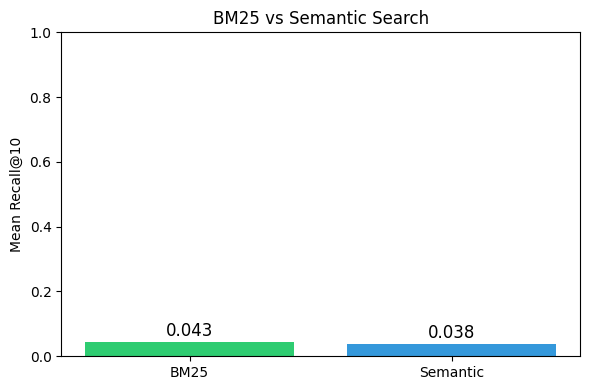

In [32]:
# Visualize comparison
fig, ax = plt.subplots(figsize=(6, 4))
methods = ["BM25", "Semantic"]
means = [eval_df["recall_bm25"].mean(), eval_df["recall_semantic"].mean()]
ax.bar(methods, means, color=["#2ecc71", "#3498db"])
ax.set_ylabel(f"Mean Recall@{k}")
ax.set_title("BM25 vs Semantic Search")
ax.set_ylim(0, 1)
for i, v in enumerate(means):
    ax.text(i, v + 0.02, f"{v:.3f}", ha="center", fontsize=12)
plt.tight_layout()
plt.show()


---

## Task 5: Compare Embedding Models (20 points)

### 5a. Embed products with two different models (10 pts)

Compare embeddings from:
- `BAAI/bge-base-en-v1.5`
- `sentence-transformers/all-mpnet-base-v2`

In [33]:
# Load the two embedding models
model_bge = SentenceTransformer("BAAI/bge-base-en-v1.5")
model_mpnet = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")
print("BGE embedding dim:", model_bge.get_sentence_embedding_dimension())
print("MPNet embedding dim:", model_mpnet.get_sentence_embedding_dimension())

Loading weights: 100%|██████████| 199/199 [00:00<00:00, 687.48it/s, Materializing param=pooler.dense.weight]                               
BertModel LOAD REPORT from: BAAI/bge-base-en-v1.5
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Loading weights: 100%|██████████| 199/199 [00:00<00:00, 732.02it/s, Materializing param=pooler.dense.weight]                        
MPNetModel LOAD REPORT from: sentence-transformers/all-mpnet-base-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


BGE embedding dim: 768
MPNet embedding dim: 768


In [34]:
# Embed products with both models (same combined_text as in 3a)
texts = products_sample["combined_text"].tolist()
embeddings_bge = model_bge.encode(texts, show_progress_bar=True)
embeddings_mpnet = model_mpnet.encode(texts, show_progress_bar=True)
print(f"BGE shape: {embeddings_bge.shape}")
print(f"MPNet shape: {embeddings_mpnet.shape}")


Batches: 100%|██████████| 157/157 [00:54<00:00,  2.89it/s]


BGE shape: (5000, 768)
MPNet shape: (5000, 768)


### 5b. Compare search results between models (10 pts)

Evaluate both models on the same queries and analyze differences.

In [35]:
# Evaluate both BGE and MPNet on the same queries (queries_filtered from 4b)
k = 10
model_compare_results = []

for _, row in queries_filtered.iterrows():
    query_id = row["query_id"]
    query_text = row["query"]
    relevant_ids = query_relevant[query_id]

    res_bge = semantic_search(query_text, embeddings_bge, products_sample, model_bge, k=k)
    res_mpnet = semantic_search(query_text, embeddings_mpnet, products_sample, model_mpnet, k=k)

    recall_bge = recall_at_k(res_bge["product_id"].tolist(), relevant_ids, k)
    recall_mpnet = recall_at_k(res_mpnet["product_id"].tolist(), relevant_ids, k)

    model_compare_results.append({
        "query_id": query_id,
        "query": query_text,
        "recall_bge": recall_bge,
        "recall_mpnet": recall_mpnet,
    })

model_compare_df = pd.DataFrame(model_compare_results)
print("Mean Recall@10 — BGE:  ", model_compare_df["recall_bge"].mean())
print("Mean Recall@10 — MPNet:", model_compare_df["recall_mpnet"].mean())
model_compare_df.head(10)

Mean Recall@10 — BGE:   0.03833907805121391
Mean Recall@10 — MPNet: 0.036416912430376765


,query_id,query,recall_bge,recall_mpnet
0,0,salon chair,0.003316,0.003316
1,1,smart coffee table,0.007052,0.007052
2,2,dinosaur,0.063291,0.063291
3,3,turquoise pillows,0.012953,0.012953
4,4,chair and a half recliner,0.005263,0.015789
5,5,sofa with ottoman,0.007639,0.007639
6,6,acrylic clear chair,0.020202,0.020202
7,7,driftwood mirror,0.018692,0.018692
8,8,home sweet home sign,0.031915,0.042553
9,9,coffee table fire pit,0.006623,0.005298


In [36]:
# Compare results for specific queries
test_queries = ["comfortable sofa", "star wars rug", "modern coffee table", "coffee beans", "pokemon", "laptop"]

for q in test_queries:
    print(f"\n--- '{q}' ---")
    bge_top = semantic_search(q, embeddings_bge, products_sample, model_bge, k=5)
    mpnet_top = semantic_search(q, embeddings_mpnet, products_sample, model_mpnet, k=5)
    print("BGE top 3:", bge_top["product_name"].head(3).tolist())
    print("MPNet top 3:", mpnet_top["product_name"].head(3).tolist())


--- 'comfortable sofa' ---
BGE top 3: ['baeten patio sofa with cushions', "94 '' square arm sofa with reversible cushions", "mccaffery 74 '' round arm sofa"]
MPNet top 3: ['arshleen patio sofa with cushions', 'aidann patio sectional with cushions', 'lucey patio sectional with cushions']

--- 'star wars rug' ---
BGE top 3: ['dinosaur land area rug', 'trisler hand-tufted gray/beige area rug', 'dunfries geometric shag gray/white area rug']
MPNet top 3: ['runner brandt oriental hand-knotted wool beige area rug', 'rugsotic carpets hand-knotted silk blue area rug', 'novelty shayne patchwork cowhide leather gradient gray rug']

--- 'modern coffee table' ---
BGE top 3: ['coffee table with storage', 'florie solid coffee table', 'tacto solid wood block coffee table']
MPNet top 3: ['coffee table', 'updegraff contemporary rect coffee table', 'choual coffee table']

--- 'coffee beans' ---
BGE top 3: ['big joe nestle large bean bag lounger', 'guzik bohemian shells coffee mug', 'amarillo coffee mug'

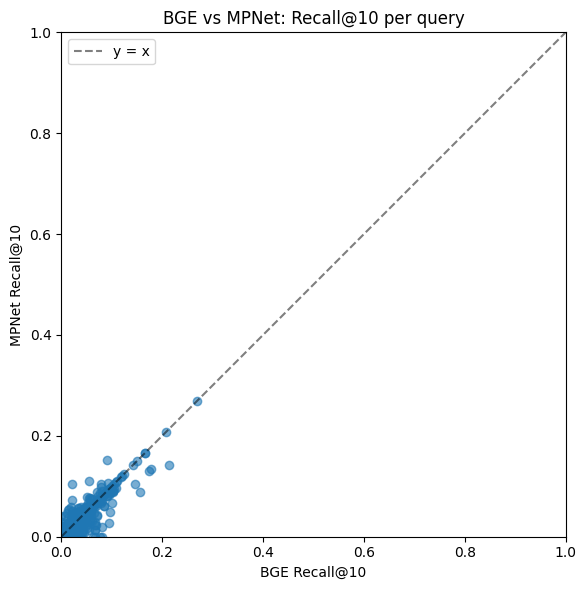

In [37]:
# Visualize model comparison with a scatter plot
# X-axis: BGE Recall@10, Y-axis: MPNet Recall@10
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(model_compare_df["recall_bge"], model_compare_df["recall_mpnet"], alpha=0.6)
ax.plot([0, 1], [0, 1], "k--", alpha=0.5, label="y = x")
ax.set_xlabel("BGE Recall@10")
ax.set_ylabel("MPNet Recall@10")
ax.set_title("BGE vs MPNet: Recall@10 per query")
ax.legend()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_aspect("equal")
plt.tight_layout()
plt.show()

---

## Task 6: Git Submission (5 points)

Submit your work using the Git workflow:

- [ ] Create a new branch called `homework-4`
- [ ] Commit your work with a meaningful message
- [ ] Push to GitHub
- [ ] Create a Pull Request
- [ ] Merge the PR to main
- [ ] Submit the `.ipynb` file on Blackboard

The TA will verify your submission by checking the merged PR on GitHub.